+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 17
State: 475
Action: 5
Reward: 20


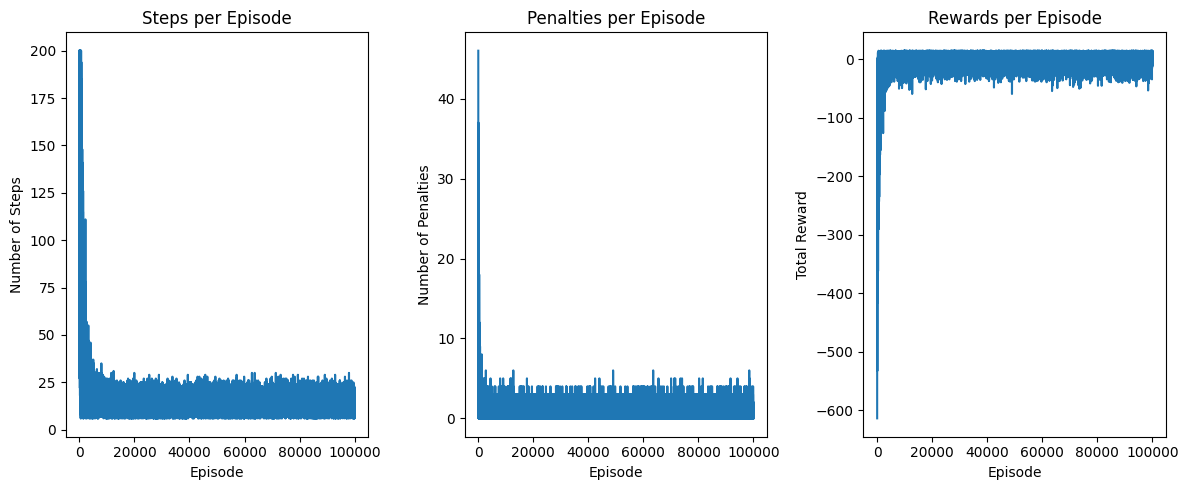

Results after 100 episodes:
Average timesteps per episode: 13.06
Average penalties per episode: 0.0
Average reward per episode: 7.94


In [2]:
# Install necessary packages
!pip install cmake 'gym[atari]' scipy

import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
import numpy as np
import random
import pickle

# Create the Taxi environment
env = gym.make('Taxi-v3')

# Reset the environment to the starting state
env.reset()

# Print the action space and state space
print('Action space:', env.action_space)
print('State space:', env.observation_space)

# Encode a specific state and set it as the current state of the environment
state = env.encode(3, 1, 2, 0)
print('Encoded State:', state)

# Set the environment to the encoded state
env.s = state

# Render the new state of the environment
env.render()

# Initialize Q-table with zeros
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.6  # Discount factor
epsilon = 0.1  # Exploration rate

# For plotting metrics
all_epochs = []
all_penalties = []
all_rewards = []

# Training the agent using Q-learning
for i in range(1, 100001):  # Train for 100,000 episodes
    state = env.reset()  # Reset the environment to the initial state
    epochs, penalties, total_reward = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        next_state, reward, done, info = env.step(action)  # Take the action

        old_value = q_table[state, action]  # Current Q-value
        next_max = np.max(q_table[next_state])  # Max Q-value for the next state

        # Update Q-value using the Q-learning formula
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:  # Check if the agent incurred a penalty
            penalties += 1

        state = next_state  # Update the state
        total_reward += reward
        epochs += 1

    all_epochs.append(epochs)
    all_penalties.append(penalties)
    all_rewards.append(total_reward)

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Average timesteps per episode: {np.mean(all_epochs[-100:])}")
        print(f"Average penalties per episode: {np.mean(all_penalties[-100:])}")
        print(f"Average reward per episode: {np.mean(all_rewards[-100:])}")

print("Training finished.\n")

# Save the Q-table
with open('q_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)

# Function to print frames
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(0.1)

# Evaluation of the trained agent
state = env.reset()  # Reset the environment to the initial state
env.s = state
epochs, penalties, reward = 0, 0, 0
done = False

frames = []  # List to store frames for rendering

while not done:
    action = np.argmax(q_table[state])  # Select the best action
    state, reward, done, info = env.step(action)  # Take the action

    if reward == -10:
        penalties += 1

    # Capture the frame
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
    })
    epochs += 1

print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

# Print the captured frames
print_frames(frames)

# Plotting the training results
plt.figure(figsize=(12, 5))

# Plotting epochs per episode
plt.subplot(1, 3, 1)
plt.plot(all_epochs)
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.title('Steps per Episode')

# Plotting penalties per episode
plt.subplot(1, 3, 2)
plt.plot(all_penalties)
plt.xlabel('Episode')
plt.ylabel('Number of Penalties')
plt.title('Penalties per Episode')

# Plotting rewards per episode
plt.subplot(1, 3, 3)
plt.plot(all_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')

plt.tight_layout()
plt.show()

# Evaluating agent's performance after Q-learning
total_epochs, total_penalties, total_rewards = 0, 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        action = np.argmax(q_table[state])  # Follow the policy derived from Q-table
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        total_rewards += reward
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
print(f"Average reward per episode: {total_rewards / episodes}")

# Load the Q-table for further use
with open('q_table.pkl', 'rb') as f:
    q_table = pickle.load(f)
